# Step 3: standardization of the TPM-normalized matrix

Made by: Cynthia Soto <br>
Date: March 19, 2021 <br>
Last md: June 1, 2022 <br>

**Assumptions:** <br>
1. Data are a tvs file with the TPM-values

**Code goal:** <br>
1. It filter genes with TPM values out of the range of interest. It seeks to obtain a data frame under a criterion that maintains the TPM values between the 1st and 99th percentile. <br>
    1. The genes to be removed in the MINIMUM THRESHOLD are genes with values <0.1 and underrepresented in the dataset in at least 70% of the samples.
    2. The genes to be removed in the MAXIMUM THRESHOLD are genes above to 99th percentile. <br>
2. Get some stats and distributions.  
3. Plot. 

In [1]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [2]:
# Set the directory to parse and the base_name of the dataset 
# notice all plots and files will use this base_name to label objects)

#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the main and temporary files. 

###   Choose what dataset you are going to process
#general_titles="healthy"
general_titles="infected"

In [3]:
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


### Declare functions

In [51]:
# Plot the distributions: values are TPM normalized
def plot_KDE2(df, samples, y_label):
    ## @df: the array(df) to be plotted (w/o column gene's names)
    ## @samples: the names to be displayed in the leyend label
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the "y" axis label.
       
    # Plot Designs for paper figure
    plt.figure(figsize=(7,4), dpi= 300)
    title_fs = 14
    xlab_fs = 12
    ylab_fs = 12
    xtick_fs = 10
    leyend_fs = 9
    titulo = 'Histogram with KDE for a normalized & standardized dataset' 
    
    sns.set_style("white")
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})
    plt.rc('xtick',labelsize = xtick_fs)
    plt.rc('ytick',labelsize = xtick_fs)
    
    np_array = df.to_numpy()         # number of samples
    x = len(sample_lst)

    for i in range(1, x):
        sample_data = np_array[:,i]
        sns.distplot(sample_data, label = samples[i], **kwargs)   #color="dodgerblue", 
    
    plt.title(titulo, fontsize = title_fs);
    plt.xlabel(y_label,fontsize = xlab_fs);
    plt.ylabel('Probability Density',fontsize = ylab_fs);
#    plt.legend(loc='center right', fontsize = leyend_fs);    
    plt.legend("")
    #adding text inside the plot
#     plt.text(9000, 0.008, 'INPUT:\nTPM[raw-count] values', fontsize = 12,
#             bbox = dict(facecolor = 'red', alpha = 0.5))
    
    ## add arbitrary lines to canvas
    x1, y1 = [50, 800], [0.03, 0.005]
    plt.plot(x1, y1, 'k-', lw=1, color='blue', marker = "8")  
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [6]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [7]:
# Filter a dataframe by column value (I use a cutoff threshold)
def filter_low_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

def filter_high_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] <= v]
    return df_cut

In [8]:
# Plot a bar-chart as the result of the dataframe describe() function over an expression array (df)
def plot_intercuartile_bar(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="max", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

# Set ID index as "ID" to trigger the describe() function over a dataframe    
def df_with_label_ID(df_stat):
    try:
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [9]:
# Plot a line-chart with the mean and std.dev as the result of the dataframe describe() function over an expression array (df)
def plot_mean_sdev_line(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
  
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [10]:
# plot the maximum values of a given df
def plot_maximum_values(df, title, perc):
    maxValues = df.max(axis = 1)
    #maxValues.sort_values(axis=0, ascending=True)
    #print(maxValues)
    maxValues.plot()
    plt.title("Matrix C: maximum TPM values for Athal " + title, fontsize = 14)
    plt.ylabel("Maximum TPM", fontsize = 14)
    plt.xlabel("Genes", fontsize = 14)
    if perc > 0: 
        plt.axhline(y=perc, color='b', linestyle='-')
    
    return

In [11]:
 #Build a violin subplot chat with the option to include a swarmplot distribution
def violin_plot_inf(dfx, s_type, atypical, b_swarm, ylab):
    # @dfx: array (expr.matrix)
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")
    plt.rc('xtick',labelsize=1)
    plt.rc('ytick',labelsize=13)
    
    if atypical==2:
        fig = plt.figure(figsize=(4, 4))
        gs = fig.add_gridspec(1, 3)        # grid spaces for 3 samples
    elif atypical==1:
        fig = plt.figure(figsize=(12, 4))
        gs = fig.add_gridspec(1, 14)       # grid spaces for 14 samples
    elif atypical==0:
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(1, 17)       # grid spaces for 17 samples

    if atypical==0 or atypical==1:   #(1 is not plot atypical samples)
        ## Assign the column to a pandas serie for botrytis
        Bc12 = dfx['Bc12']
        Bc12r = dfx['Bc12.1']
        Bc18 = dfx['Bc18']
        Bc18r = dfx['Bc18.1']
        Bc24 = dfx['Bc24']
        Bc24r = dfx['Bc24.1']
        ## Assign the column to a pandas serie for Colletotrichum
        Ch22 = dfx['Ch22']
        Ch22r1 = dfx['Ch22.1']
        Ch22r2 = dfx['Ch22.2']
        Ch22r3 = dfx['Ch22.3']
        Ch40 = dfx['Ch40']
        Ch40r1 = dfx['Ch40.1']
        Ch40r2 = dfx['Ch40.2']
        Ch40r3 = dfx['Ch40.3']
    if atypical==0 or atypical==2:
        print("Preparing series for all atypical")
        ## Assign the column to a pandas serie for Ss
        Ss = dfx['Ss30']
        Ssr1 = dfx['Ss30.1']
        Ssr2 = dfx['Ss30.2'];

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    if atypical==2:           # atypicals
        ## Sclerotinia
        #ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)
        sns.violinplot(data=Ss, palette='pink')
        if b_swarm: sns.swarmplot(data=Ss, color="k", alpha=0.8)
        ax1.set_xlabel("Ss30", fontsize=14)
        ax1.set_ylabel(ylab,fontsize=16)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=Ssr1, palette='pink')
        if b_swarm: sns.swarmplot(data=Ssr1, color="k", alpha=0.8)
        ax2.set_xlabel("Ss30.1", fontsize=14)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=Ssr2, palette='pink')
        if b_swarm: sns.swarmplot(data=Ssr2, color="k", alpha=0.8)
        ax3.set_xlabel("Ss30.2", fontsize=14)
    elif atypical==1 or atypical==0:     
        # 1 = all with out atypical samples
        # 0 = all samples       
        #ax1 = fig.add_subplot(gs[0, 0])
        sns.violinplot(data=Bc12, palette='Accent')
        ax1.set_xlabel("Bc12", fontsize=14)
        ax1.set_ylabel(ylab,fontsize=16)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=Bc12r, palette='Accent')
        ax2.set_xlabel("Bc12.1", fontsize=14)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=Bc18, palette='Reds')
        ax3.set_xlabel("Bc18", fontsize=14)
        #ax3.set_title('**Zeros in common removed and Q3 threshold',fontsize=13)

        ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
        sns.violinplot(data=Bc18r, palette='Reds')
        ax4.set_xlabel("Bc18.1", fontsize=14)

        ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
        sns.violinplot(data=Bc24, palette='Greens')
        ax5.set_xlabel("Bc24", fontsize=14)

        ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
        sns.violinplot(data=Bc24r, palette='Greens')
        ax6.set_xlabel("Bc24.1", fontsize=14)

        ## Colletrotrichum
        ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
        sns.violinplot(data=Ch22, palette='Purples')
        ax7.set_xlabel("Ch22", fontsize=14)

        ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
        sns.violinplot(data=Ch22r1, palette='Purples')
        ax8.set_xlabel("Ch22.1", fontsize=14)

        ax9 = fig.add_subplot(gs[0, 8])
        sns.violinplot(data=Ch22r2, palette='Purples')
        ax9.set_xlabel("Ch22.2", fontsize=14)

        ax10 = fig.add_subplot(gs[0, 9], sharey=ax1)
        sns.violinplot(data=Ch22r3, palette='Purples')
        ax10.set_xlabel("Ch22.3", fontsize=14)

        ax11 = fig.add_subplot(gs[0, 10], sharey=ax1)
        sns.violinplot(data=Ch40, palette='Blues')
        ax11.set_xlabel("Ch40", fontsize=14)

        ax12 = fig.add_subplot(gs[0, 11], sharey=ax1)
        sns.violinplot(data=Ch40r1, palette='Blues')
        ax12.set_xlabel("Ch40.1", fontsize=14)

        ax13 = fig.add_subplot(gs[0, 12], sharey=ax1)
        sns.violinplot(data=Ch40r2, palette='Blues')
        ax13.set_xlabel("Ch40.2", fontsize=14)

        ax14 = fig.add_subplot(gs[0, 13], sharey=ax1)
        sns.violinplot(data=Ch40r3, palette='Blues')
        ax14.set_xlabel("Ch40.3", fontsize=14)      
        if atypical==0:
            ## Sclerotinia
            #ax15 = fig.add_subplot(gs[0, 0], sharey=ax15)
            ax15 = fig.add_subplot(gs[0, 14], sharey=ax1)
            sns.violinplot(data=Ss, palette='pink')
            ax15.set_xlabel("Ss30", fontsize=14)

            ax16 = fig.add_subplot(gs[0, 15], sharey=ax1)
            sns.violinplot(data=Ssr1, palette='pink')
            ax16.set_xlabel("Ss30.1", fontsize=14)

            ax17 = fig.add_subplot(gs[0, 16], sharey=ax1)
            sns.violinplot(data=Ssr2, palette='pink')
            ax17.set_xlabel("Ss30.2", fontsize=14)   

        if atypical==2:  # atypicals 
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            fig.suptitle(s_type + ". Violin plots with KDE for Ss30 samples "+general_titles, fontsize=18)
        else:            # all or w/o atypicals
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            plt.setp(ax4.get_yticklabels(), visible=False)
            plt.setp(ax5.get_yticklabels(), visible=False)
            plt.setp(ax6.get_yticklabels(), visible=False)
            plt.setp(ax7.get_yticklabels(), visible=False)
            plt.setp(ax8.get_yticklabels(), visible=False)
            plt.setp(ax9.get_yticklabels(), visible=False)
            plt.setp(ax10.get_yticklabels(), visible=False)
            plt.setp(ax11.get_yticklabels(), visible=False)
            plt.setp(ax12.get_yticklabels(), visible=False)
            plt.setp(ax13.get_yticklabels(), visible=False)
            plt.setp(ax14.get_yticklabels(), visible=False)   
            if atypical==0:
                plt.setp(ax15.get_yticklabels(), visible=False)
                plt.setp(ax16.get_yticklabels(), visible=False)
                plt.setp(ax17.get_yticklabels(), visible=False)                     
                fig.suptitle(s_type + ". Violin plots with KDE for A.thaliana "+ general_titles, fontsize=18)
            else: 
                fig.suptitle(s_type + ". Violin plots with KDE for A.thaliana infected / No Ss30 samples", fontsize=18) 
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    
    return

In [12]:
# Build a violin subplot chat with the option to include a swarmplot distribution
def violin_plot_healthy(dfx, s_type, atypical, b_swarm, ylab):
    # @dfx: array (expr.matrix)
    # @s_type: type of matrix A, B, C, D or E
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(1, 8)            # grid spaces for 8 samples    
    plt.rc('xtick',labelsize=1)
    plt.rc('ytick',labelsize=13)

    # prepare series ############################################################################################      
    H12=dfx['healthy12']
    H12r=dfx['healthy12.1']
    H18=dfx['healthy18']
    H18r=dfx['healthy18.1']
    H24=dfx['healthy24']
    H24r=dfx['healthy24.1']
    H30=dfx['healthy30']
    H30r=dfx['healthy30.1']

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    sns.violinplot(data=H12, palette='Reds')
    ax1.set_xlabel("H12",fontsize=14)
    ax1.set_ylabel(ylab,fontsize=16)

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    sns.violinplot(data=H12r, palette='Greens')
    ax2.set_xlabel("H12.1",fontsize=14)

    ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
    sns.violinplot(data=H18, palette='pink')
    ax3.set_xlabel("H18",fontsize=14)

    ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
    sns.violinplot(data=H18r, palette='Accent')
    ax4.set_xlabel("H18.1",fontsize=14)

    ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
    sns.violinplot(data=H24, palette='Reds')
    ax5.set_xlabel("H24",fontsize=14)

    ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
    sns.violinplot(data=H24r, palette='Greens')
    ax6.set_xlabel("H24.1",fontsize=14)

    ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
    sns.violinplot(data=H30, palette='pink')
    ax7.set_xlabel("H30",fontsize=14)

    ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
    sns.violinplot(data=H30r, palette='Accent')
    ax8.set_xlabel("H30.1",fontsize=14)

    # prepare labels #####################################################################################
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    plt.setp(ax5.get_yticklabels(), visible=False)
    plt.setp(ax6.get_yticklabels(), visible=False)
    plt.setp(ax7.get_yticklabels(), visible=False)
    plt.setp(ax8.get_yticklabels(), visible=False)
    fig.suptitle(s_type + ". Violin plot with KDE for A.thaliana "+ general_titles, fontsize=18)
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    
    return

## Load your TPM matrix

In [13]:
file_name = "matrix_B_" + general_titles.strip() +".csv"
file_name

'matrix_B_infected.csv'

In [14]:
df_expr=pd.read_csv(file_name, header=0, sep=',')
print(len(df_expr))
df_expr.head(3)

24239


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


## Calculate the sample's distribution of the matrix B (TPM normalized)

In [15]:
# chk the distribution
df_plot = df_expr.drop(['Genes'], axis=1)   #, inplace = True
## Get sample list names
sample_lst=df_plot.columns
sample_lst=sample_lst.to_list()
print(sample_lst)

['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2', 'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18', 'Bc24', 'Ss30', 'Ch40']


In [16]:
violin_plot_inf

<function __main__.violin_plot_inf(dfx, s_type, atypical, b_swarm, ylab)>

Preparing series for all atypical


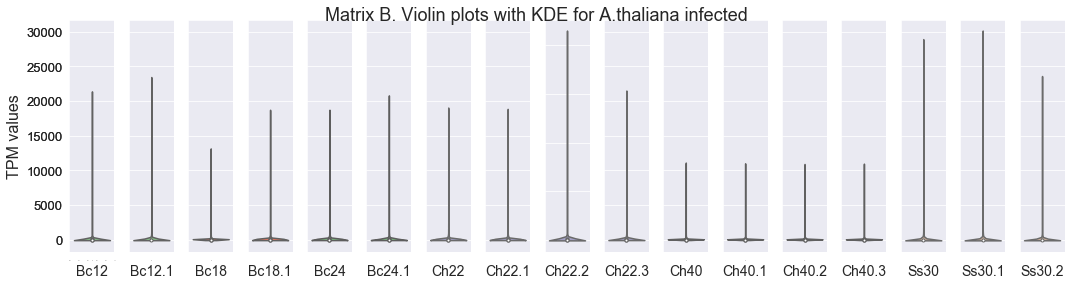

In [17]:
if general_titles == 'infected':
    violin_plot_inf(df_plot, "Matrix B", 0, False, 'TPM values')
    # @atypical: 
    #       0 = all samples
    #       1 = all with out atypical samples 
    #       2 = only atypical 
else:
    violin_plot_healthy(df_plot, "Matrix B", general_titles.strip(), 0, 'TPM values')    

## TPM standarization: 
### The process consists on calculate the number of ocurrences where genes have low and hight extreme TPM values and decide under wich threshold cut off values

CV obviously depends very strongly on mean expression such that lowly expressed genes are going to tend to have much higher CV. Therefore, we cannot trust the CV of very lowly expressed genes, and so these should be filtered out of your analysis. If you want a well tested expression filtering scheme, you could use GTEx's scheme (Genes were selected based on expression thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples).

For my own analysis, deleting genes with no counts in at least 70% of the dataset seems convenient, because these genes are underrepresented. And, high quantities of expression levels underrepresented need to be removed to reduce noise in the coexpression analysis in most of the cases. Of course, the biology issue will weigh more than the technical issues. <br>
***Let's start with the counting of genes in zeros***

In [18]:
## Check number of zeros by sample
sr_ceros = df_expr.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [19]:
df_ceros[0:5]

,0
Genes,0
Ss30.1,7185
Bc12,4103
Ch40.2,3702
Ch22.2,3770


***Validate that none gene has TPM equal to zero across all samples***

In [20]:
s_zeros = (df_expr == 0.000).astype(int).sum(axis=1)
## Added a column to df1 with the counter of zeros
df_expr['zero-counter'] = s_zeros
df_expr.head(3)     # see ID=13 for exampling

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


In [21]:
i_samples = len(df_expr.columns) - 2              # need to substract "Gene & zero-counter" from the operation
i_samples

17

In [22]:
df_expr[(df_expr['zero-counter'] == i_samples)]

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter


## Now, calculate the number of ocurrences by gene(row) where:
zero-counter in at least 70% of the samples <br>
Low_TPM <= 0.1 in at least 70% of the samples

In [23]:
# drop this column, no need more
#df_expr.drop(['zero-counter'], inplace=True, axis=1)
df_expr.head(3)
df_expr.tail(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
24236,ATMG01370,2.043,11.322,107.077,101.205,70.613,80.439,7.157,106.246,9.812,6.911,8.329,107.960,131.528,12.506,7.910,10.672,129.172,0
24237,ATMG01400,0.000,0.000,1.640,0.548,0.541,0.548,0.000,1.667,0.000,0.000,0.000,3.275,1.759,0.000,0.000,0.000,0.586,9
24238,ATMG01410,0.372,1.326,7.348,4.537,5.032,5.104,0.000,6.897,0.357,0.000,0.284,5.080,6.064,1.068,0.144,0.833,3.029,2


In [24]:
# ilast_sample = len(df_expr.columns) 
# ilast_sample
i70 = int((((len(df_expr.columns)-3)*0.7)+1))
i70
# Athal healthy       5.6 + 1(zero-counter) = 6 (truncado)
# Athal infected      11.9 +1(zero-counter) = 12 (truncado)

12

In [25]:
is_zero = (df_expr['zero-counter'] >= i70)  

In [26]:
df_zero = df_expr[is_zero]
print('genes with 70% of zeros thru the samples:',len(df_zero))
df_zero.head(3)

genes with 70% of zeros thru the samples: 3081


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
13,AT1G01150,0.0,0.0,0.0,0.0,0.0,0.0,0.213,0.0,0.0,0.047,0.0,0.0,0.0,0.0,0.141,0.0,0.0,14
26,AT1G01280,0.0,0.0,0.0,0.0,0.0,0.0,0.124,0.0,0.0,0.608,0.0,0.0,0.0,0.0,0.493,0.0,0.0,14
29,AT1G01305,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.416,0.0,0.0,16


In [27]:
print(len(df_expr))
df1 = df_drop_idx_list(df_zero,df_expr)
print(len(df1))
df1.head(3)

24239
21158


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


## TPM standarization: criteria 1
**Drop genes with high number of occurrences in Low_TPM field** <br>
**For my own analysis:** TPM<=0.1 in at least 70% of the samples <br>
e.g: Athal.Infected has 17 samples, thus: <br>
17 x 0.70 = 11.9; rounded the result the criteria sets: Low_TMP >= 12

In [28]:
# Athal healthy       5.6 + 1(zero-counter) = 6 (truncado)
# Athal infected      11.9 +1(zero-counter) = 12 (truncado)
# g.e: df_expr["Low_TPM"] = df_expr.apply(lambda row: sum(row[1:18]<=0.1) ,axis=1)

df_expr.drop(['zero-counter'], inplace=True, axis = 1) 
ilast_sample = len(df1.columns) - 1
ilast_sample

18

In [29]:
df_expr["Low_TPM"] = df_expr.apply(lambda row: sum(row[1:ilast_sample] <= 0.100), axis=1)

In [30]:
df_expr.head(3)   

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


In [31]:
is_zero = (df_expr['Low_TPM'] >= i70)  

In [32]:
df_zero = df_expr[is_zero]
print('genes with 70% of TPM <= 0.100 thru the samples:',len(df_zero))
df_zero.head(3)

genes with 70% of TPM <= 0.100 thru the samples: 3495


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,Low_TPM
13,AT1G01150,0.0,0.0,0.0,0.0,0.0,0.0,0.213,0.0,0.0,0.047,0.0,0.0,0.0,0.0,0.141,0.0,0.0,15
26,AT1G01280,0.0,0.0,0.0,0.0,0.0,0.0,0.124,0.0,0.0,0.608,0.0,0.0,0.0,0.0,0.493,0.0,0.0,14
29,AT1G01305,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.416,0.0,0.0,16


**call the df_drop_idx_list function to delete the indexes marked**

In [33]:
print(len(df_expr))
df1 = df_drop_idx_list(df_zero,df_expr)
print(len(df1))
df1.head(3)

24239
20744


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,Low_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


In [34]:
lst_zeros_by_sample = df1.isin([0]).sum().to_list()
lst_zeros_by_sample.pop(0)        #index
lst_zeros_by_sample.pop()         #Low_TPM
lst_zeros_by_sample = (sorted(lst_zeros_by_sample))
len(lst_zeros_by_sample)

17

In [35]:
lst_zeros_by_sample
# min(lst_zeros_by_sample)
# max(lst_zeros_by_sample)

[456,
 481,
 645,
 696,
 709,
 751,
 757,
 760,
 833,
 846,
 1111,
 1113,
 1182,
 1194,
 3112,
 4022,
 4236]

Text(0, 4186, '4236')

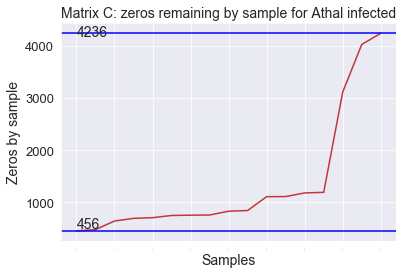

In [36]:
plt.plot(lst_zeros_by_sample)
plt.title("Matrix C: zeros remaining by sample for Athal " + general_titles, fontsize=14)
plt.ylabel("Zeros by sample",fontsize=14)
plt.xlabel("Samples", fontsize=14)
plt.axhline(y= min(lst_zeros_by_sample), color='b', linestyle='-')
plt.text(0, (min(lst_zeros_by_sample) + 50), str(min(lst_zeros_by_sample)), fontsize=14)
plt.axhline(y= max(lst_zeros_by_sample), color='b', linestyle='-')
plt.text(0, (max(lst_zeros_by_sample) - 50), str(max(lst_zeros_by_sample)), fontsize=14)   # 250 en infected

/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensi

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

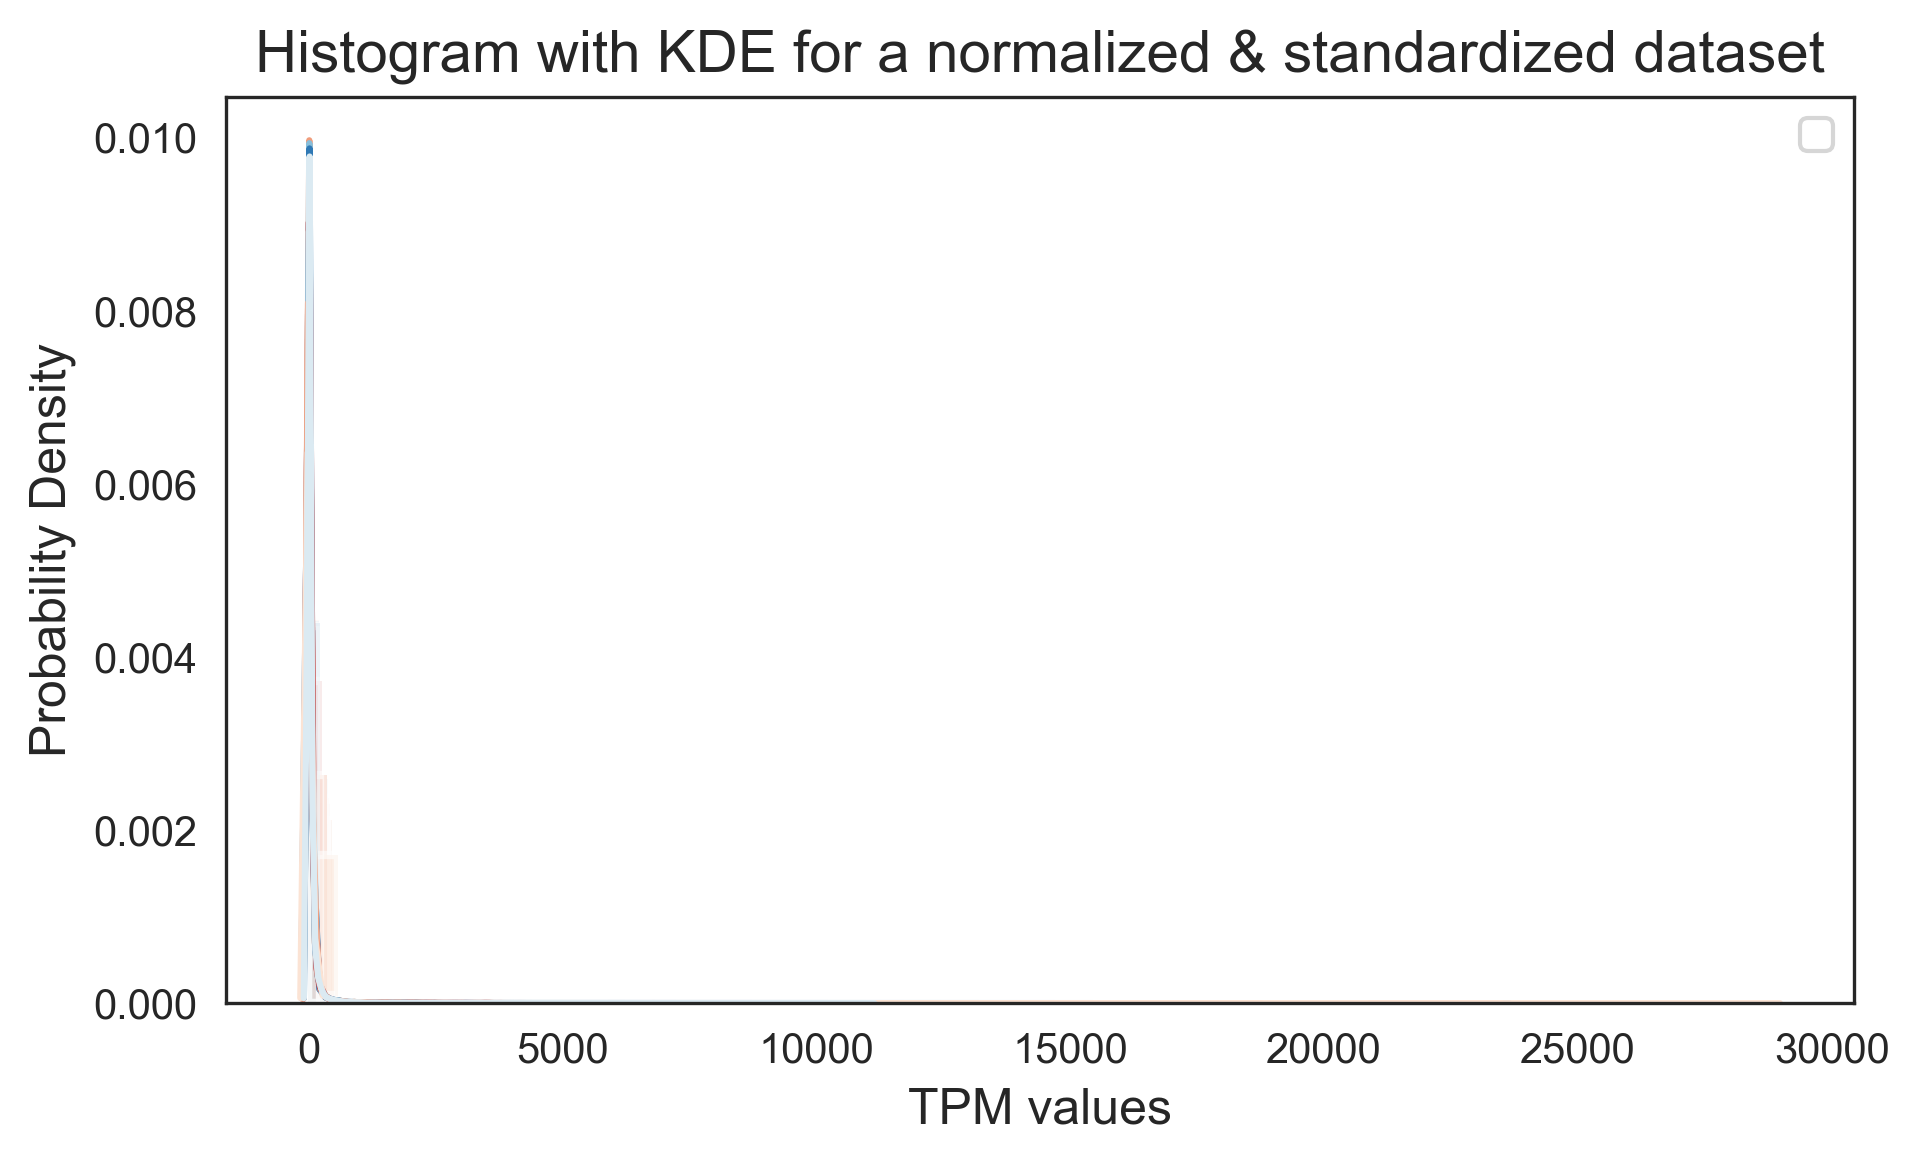

In [37]:
# chk the distribution
df_plot = df1.drop(['Genes','Low_TPM'], axis=1)  
# plot the KDE 
plot_KDE2(df_plot, sample_lst, 'TPM values')

Preparing series for all atypical


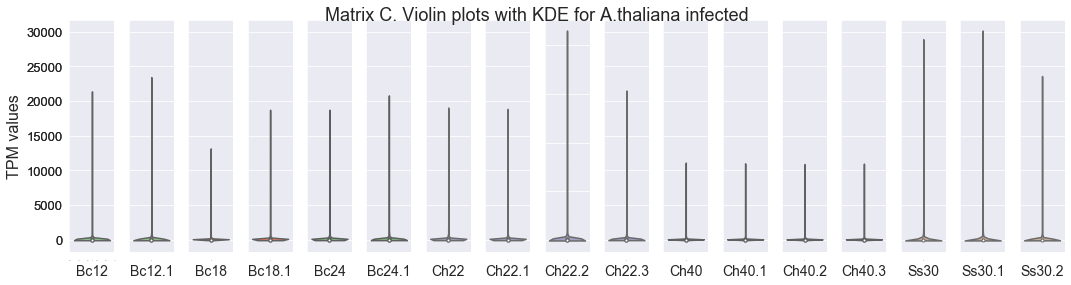

In [38]:
# athal infectes only: atypical allowed values;  0 = all samples / 1 = all with out atypical samples / 2 = only atypical    

if general_titles == 'infected':
    violin_plot_inf(df_plot, "Matrix C", 0, False, 'TPM values')
    # @atypical: 
    #       0 = all samples
    #       1 = all with out atypical samples 
    #       2 = only atypical 
else:
    violin_plot_healthy(df_plot, "Matrix C", general_titles, False, 'TPM values')   

In [39]:
df_stat = df1.describe().T
#df_stat
lst_sd = df_stat['std'].to_list()
#lst_sd = lst_sd.sort()
lst_sd.sort(reverse=True)
lst_sd

[398.9546977237883,
 386.42351616662154,
 345.3767137320145,
 297.27673689183405,
 279.3494690555869,
 273.57303742398045,
 256.16732513834967,
 249.2292142311192,
 249.0661661018539,
 248.7424742227228,
 247.9813921270002,
 247.42034980456617,
 245.60049290917624,
 227.06805555854567,
 226.6385807818984,
 216.52087006803498,
 216.40891231577658,
 2.5331211705127257]

In [40]:
df1.drop(['Low_TPM'], inplace=True, axis=1)
df1.head(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


## TPM standarization: criteria 2
**Drop genes with high number of occurrences in High_TPM field** <br>
**For my own analysis:** TPM > max(99th percentil among all the samples)

In [41]:
# first calculate the 99th percentil and get the maximun value
lst_99_quantile = df1.quantile(.99).to_list()
lst_99_quantile
perc99 = int(max(lst_99_quantile)+1)
perc99
# athal healthy is 621
# athal infected is 830 -- 845

845

In [42]:
ilast_sample
# 18 for athal infected
#  9 fir athal healthy

18

In [43]:
df1["High_TPM"] = df1.apply(lambda row: sum(row[1:ilast_sample] >= perc99) ,axis = 1)

In [44]:
df1.head(3)
#df1.tail(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,High_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


In [45]:
# count the number of genes to be dropped 
b_High_TPM = df1['High_TPM'] >= 1
df_HTPM = df1[b_High_TPM]
print("Genes above 99th percentile ("+ str(perc99) +"): ",len(df_HTPM))

Genes above 99th percentile (845):  470


/tmp/ipykernel_74481/4163795385.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maxValues = df.max(axis = 1)


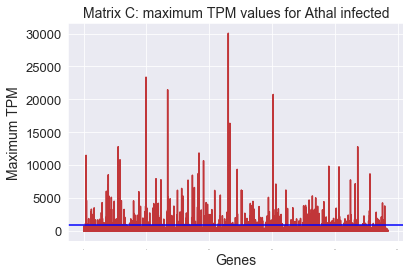

In [46]:
plot_maximum_values(df1, general_titles, perc99)

In [47]:
print(len(df1))
df1 = df_drop_idx_list(df_HTPM,df1)
print(len(df1))
df1.head(3)

20744
20274


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,High_TPM
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


/tmp/ipykernel_74481/4163795385.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maxValues = df.max(axis = 1)


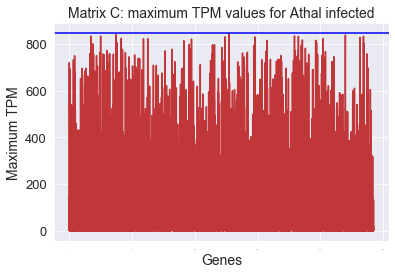

In [48]:
plot_maximum_values(df1, general_titles, perc99)

In [49]:
# chk the distribution
df_plot = df1.drop(['Genes','High_TPM'], axis=1)   #, inplace = True

/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensi

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


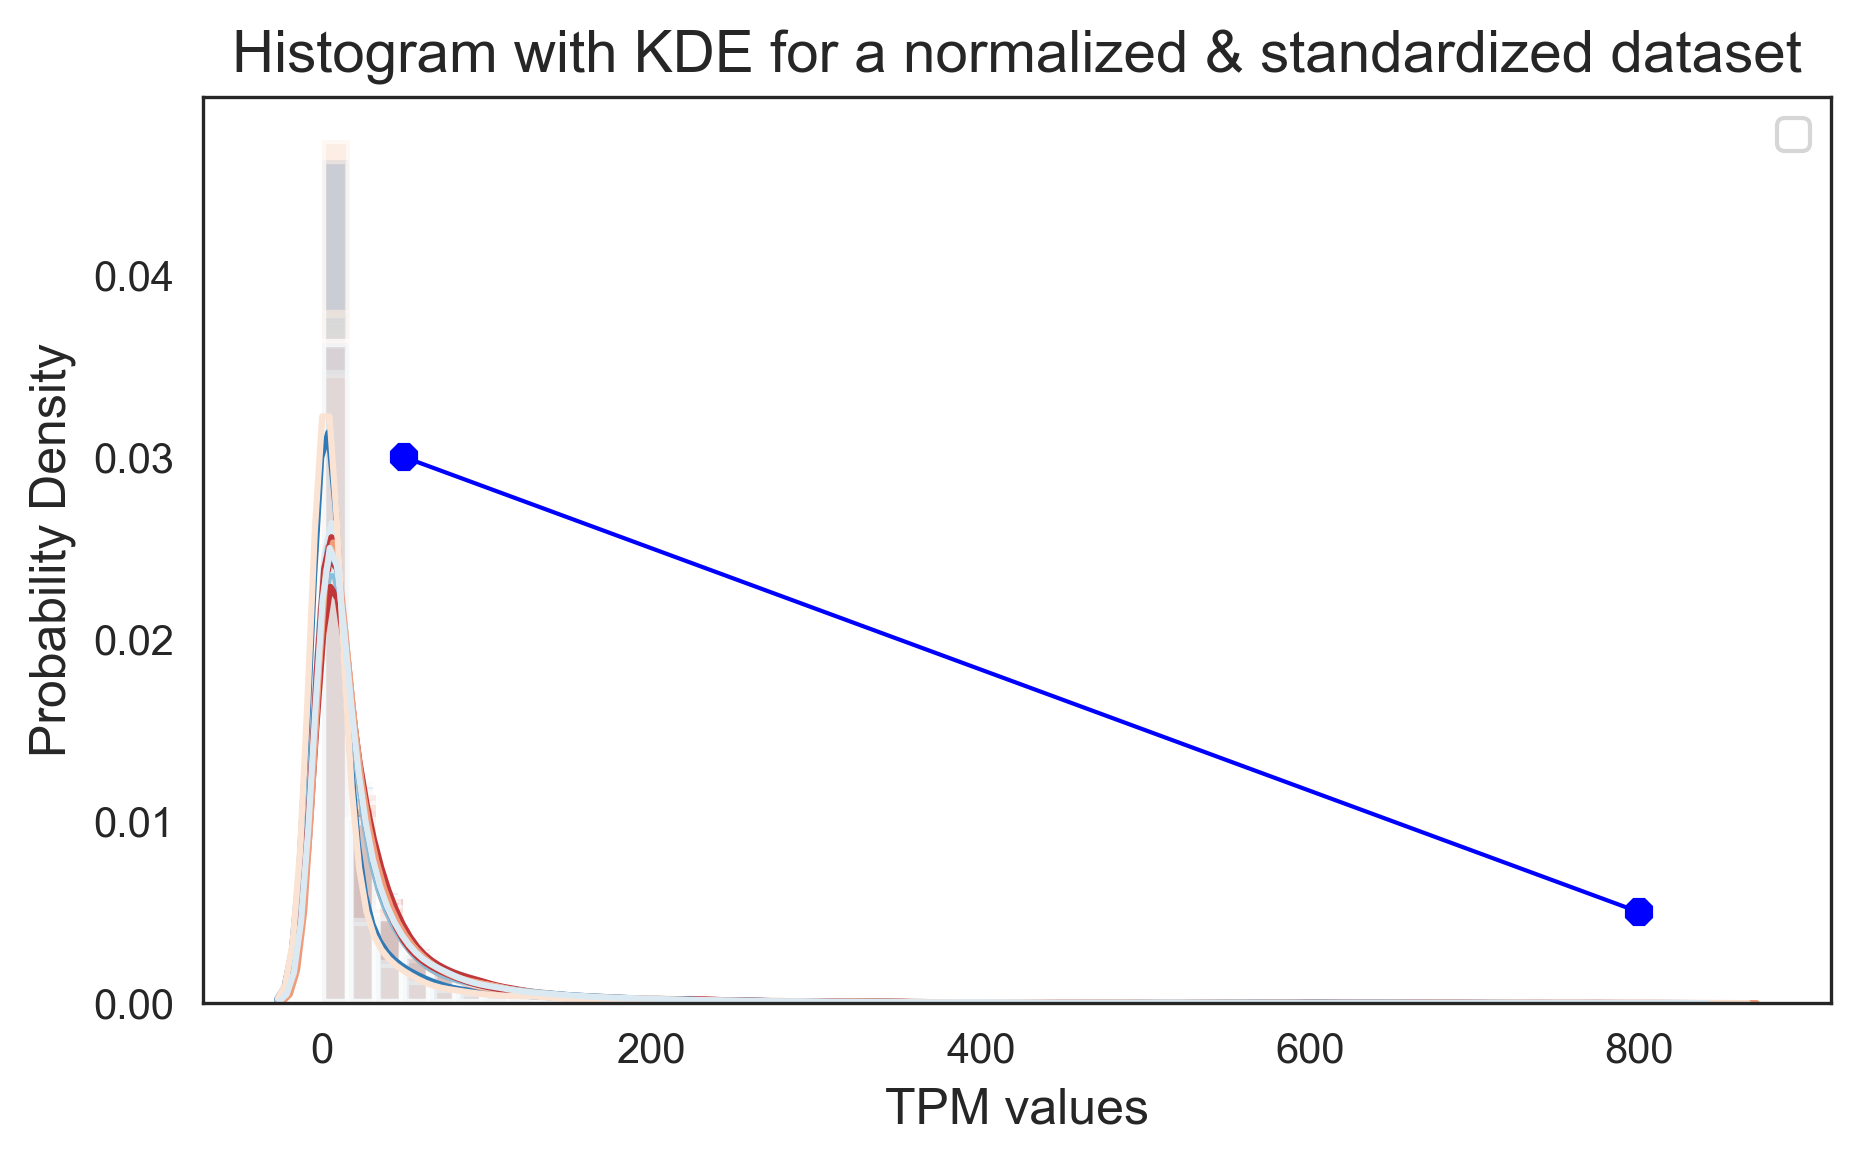

In [52]:
from importlib import reload
plt = reload(plt)

plot_KDE2(df_plot, sample_lst, 'TPM values')

Preparing series for all atypical


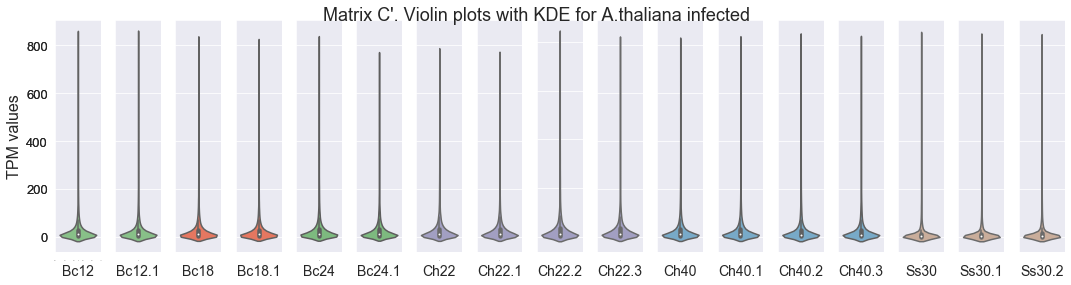

In [53]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    

if general_titles == 'infected':
    violin_plot_inf(df_plot, "Matrix C'", 0, False, 'TPM values')
    # @atypical: 
    #       0 = all samples
    #       1 = all with out atypical samples 
    #       2 = only atypical 
else:
    violin_plot_healthy(df_plot, "Matrix C'", general_titles, False, 'TPM values')   

In [54]:
# ## save the new matrix filtered of low and hight extreme values
# df1.drop(['zero-counter','Low_TPM','High_TPM'], axis=1, inplace = True)
# df1.to_csv('all_'+general_titles+'_TPM_filtered_new.csv', sep='\t', index=False)

In [55]:
## save the new matrix filtered of low and hight extreme values
df1.drop(['High_TPM'], axis=1, inplace = True)
#df1.to_csv('matrix_C_'+ general_titles +'.csv', sep='\t', index=False)

## Let's get some statistics for Matrix C

In [56]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ss30.1,20274.0,21.011,66.627,0.0,0.158,1.646,11.137,831.914
Bc12,20274.0,31.175,65.591,0.0,2.428,10.978,29.794,843.155
Ch40.2,20274.0,30.956,66.038,0.0,2.114,9.468,29.245,832.437
Ch22.2,20274.0,33.434,62.077,0.0,3.352,14.042,35.906,829.299
Ch22.1,20274.0,32.458,60.502,0.0,3.064,13.286,34.607,757.327
Ch22,20274.0,32.472,60.572,0.0,3.020,13.209,34.672,772.411
Ss30.2,20274.0,22.902,65.917,0.0,0.293,2.514,14.216,829.553
Ch22.3,20274.0,33.463,62.002,0.0,3.366,14.124,35.865,820.775
Bc12.1,20274.0,30.417,64.572,0.0,2.297,10.668,28.833,844.613
Bc24.1,20274.0,30.894,57.877,0.0,3.238,12.110,32.436,756.612


In [57]:
## save the stats of new matrix filtered
df_stat = df1.describe().T
#df_stat.to_csv("../statistics/matrix_C_stats_"+general_titles+".csv", index=True, header=True)

In [58]:
lst_stat = df_stat['std'].to_list()
lst_stat.sort()
lst_stat

[57.87654761079758,
 57.989461285846915,
 59.30710343896934,
 60.49066393613808,
 60.50172603214571,
 60.57224134665888,
 62.00192317961653,
 62.076645178417785,
 62.57695051390337,
 62.58673246693453,
 64.57167492260852,
 65.07794989406402,
 65.59054660341525,
 65.91656278731801,
 65.9952932970325,
 66.03763619362088,
 66.62668225316496]

In [59]:
df1.head(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


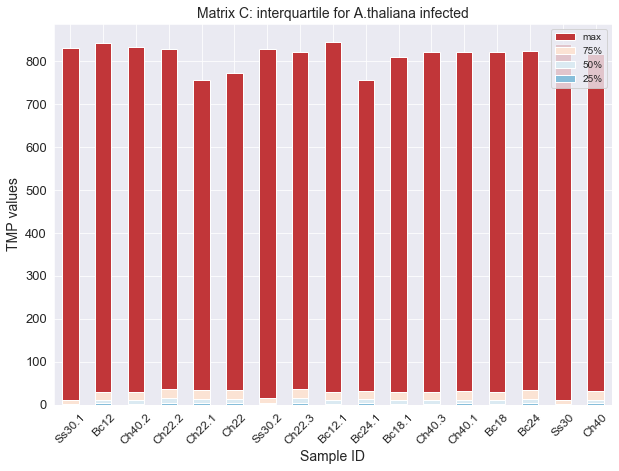

In [60]:
plot_intercuartile_bar(df_stat,  'Matrix C: interquartile for A.thaliana '+ general_titles, 'TMP values' )

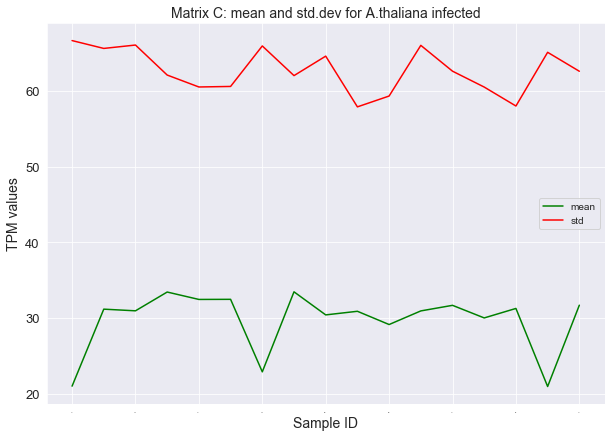

In [61]:
plot_mean_sdev_line(df_stat, 'Matrix C: mean and std.dev for A.thaliana '+ general_titles,'TPM values')